In [4]:
from s2flow.data import datasets
import os

os.chdir('/home/dhester/s2flow')

In [19]:
config = {
    'data': {
        "samples_par_path": "./data/cpb_lc/samples.par",
        "data_dir_path": "./data/cpb_lc",
        "augmentations": "spatial",
        "num_workers": 4,
        "pin_memory": True,
        "source_data": "s2sr",
        "fold": 0,
    }
}
train_dataloader, val_dataloader = datasets.get_lc_dataloaders(config)

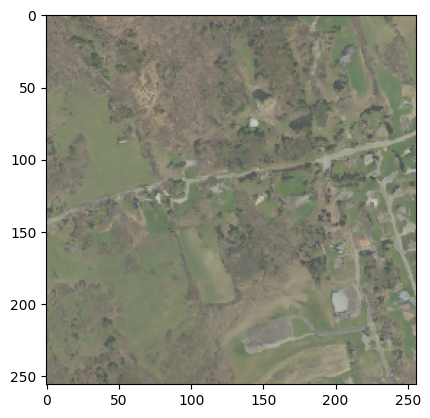

In [31]:
sample = next(iter(train_dataloader))



import matplotlib.pyplot as plt
plt.imshow(sample[0][0, :3, :, :].permute(1, 2, 0) * 3)  # Show band 4
# sample[0]

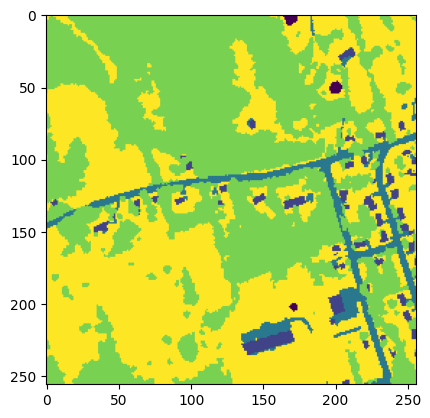

In [ ]:
plt.imshow(sample[1][0, :, :])